In [58]:
# Import things
import psycopg2
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [59]:
# Load .env variables
load_dotenv()

# Set variables to connect to  database
dbname = os.getenv("DB_NAME")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")

In [60]:
# Function to fetch data from PostgreSQL and return as DataFrame
def fetch_data_from_db(sql_query, db_connection_url):
    engine = create_engine(db_connection_url)
    df = pd.read_sql_query(sql_query, engine)
    engine.dispose()  # Close the connection
    return df

# SQL query to collect the data
sql_query = """ 
    SELECT 
        volcano_name, 
        volcano_type,
        country,
        region,
        summit_m,
        population_within_100km
    FROM volcano_schema.volcano_regional_data
"""

# Database connection URL
db_connection_url = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"

# Get data from postresql
df = fetch_data_from_db(sql_query, db_connection_url)

# print to check if the data is loaded in the df
print(df.head)

<bound method NDFrame.head of                   volcano_name       volcano_type        country  \
0                          Abu          Shield(s)          Japan   
1                   Acamarachi      Stratovolcano          Chile   
2                   Acatenango  Stratovolcano(es)      Guatemala   
3              Acigol-Nevsehir            Caldera         Turkey   
4                        Adams      Stratovolcano  United States   
...                        ...                ...            ...   
2656                  Zarechny         Caldera(s)         Russia   
2657                  Zenikame          Submarine          Japan   
2658                   Zheltiy      Stratovolcano         Russia   
2659  Zhupanovskiye Vostriyaky      Stratovolcano         Russia   
2660                   Zikwala      Stratovolcano       Ethiopia   

                              region  summit_m  population_within_100km  
0            Japan, Taiwan, Marianas       641                  4071152  
1    

In [61]:
# Create a coloumn to group the summit level 
# for cases when the volcano is above the sea level (summit_m >0)
# for cases when the volcano is below the sea level (summit_m <0)
df['sea_level_summit'] = df['summit_m'].apply(
    lambda x: 'under_sea_level' if x < 0 else 'above_sea_level'
)

# Group by sea_level_summit and country to get the count
sea_level_count = df.groupby(['sea_level_summit', 'country']).size().reset_index(name='number_of_each_type')

# Pivot the data to get under_sea_level_count and above_sea_level_count as separate columns
volcano_sea_level_by_country = sea_level_count.pivot_table(
    index='country', 
    columns='sea_level_summit', 
    values='number_of_each_type', 
    aggfunc='sum', 
    fill_value=0
).reset_index()

# Rename columns for clarity
volcano_sea_level_by_country.columns = ['country', 'above_sea_level_count', 'under_sea_level_count']

# Filter out countries that don't have a volcano that's under sea level
volcano_sea_level_by_country = volcano_sea_level_by_country[volcano_sea_level_by_country['under_sea_level_count'] > 0]

# Calculate total number of volcanoes per country
volcano_sea_level_by_country['volcano_total'] = volcano_sea_level_by_country['above_sea_level_count'] + volcano_sea_level_by_country['under_sea_level_count']

# Sort the DataFrame based on volcano_total column in descending order
volcano_sea_level_by_country = volcano_sea_level_by_country.sort_values(by='volcano_total', ascending=False)

# Display the resulting DataFrame
print(volcano_sea_level_by_country.head)

<bound method NDFrame.head of               country  above_sea_level_count  under_sea_level_count  \
93      United States                    301                     23   
45              Japan                    264                     19   
70             Russia                    256                      2   
42          Indonesia                    211                      2   
15              Chile                    157                      1   
65   Papua New Guinea                     83                      2   
29           Ethiopia                     77                      1   
67        Philippines                     72                      1   
57        New Zealand                     40                     27   
40            Iceland                     54                      1   
3          Antarctica                     47                      1   
88              Tonga                     10                     30   
12             Canada                     33   

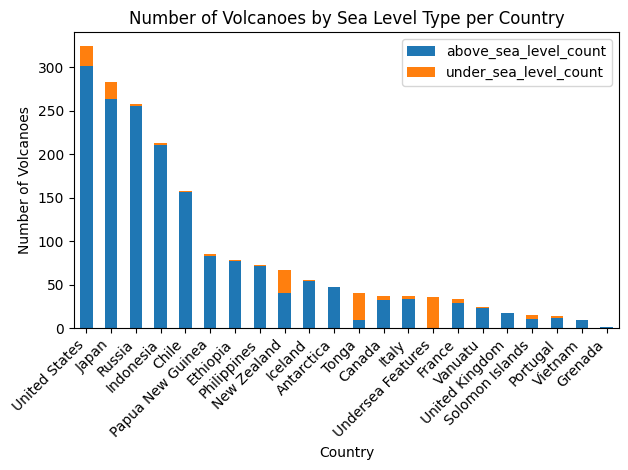

In [63]:
# Plot the number of volcanos by country that are above and below the sea level
volcano_sea_level_by_country.plot(
    x='country', 
    y=['above_sea_level_count', 'under_sea_level_count'], 
    kind='bar', 
    stacked=True
)
plt.title('Number of Volcanoes by Sea Level Type per Country')
plt.xlabel('Country')
plt.ylabel('Number of Volcanoes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [66]:
# Let's look at the percentage of volcanos below and above the sea level by countries 
# Calculate percentages
volcano_sea_level_by_country['above_sea_level_%'] = ((volcano_sea_level_by_country['above_sea_level_count'] / volcano_sea_level_by_country['volcano_total']) * 100).round(0)
volcano_sea_level_by_country['under_sea_level_%'] = ((volcano_sea_level_by_country['under_sea_level_count'] / volcano_sea_level_by_country['volcano_total']) * 100).round(0)

# Display the  DataFrame
print(volcano_sea_level_by_country[['country', 'above_sea_level_%', 'under_sea_level_%']])

              country  above_sea_level_%  under_sea_level_%
93      United States               93.0                7.0
45              Japan               93.0                7.0
70             Russia               99.0                1.0
42          Indonesia               99.0                1.0
15              Chile               99.0                1.0
65   Papua New Guinea               98.0                2.0
29           Ethiopia               99.0                1.0
67        Philippines               99.0                1.0
57        New Zealand               60.0               40.0
40            Iceland               98.0                2.0
3          Antarctica               98.0                2.0
88              Tonga               25.0               75.0
12             Canada               89.0               11.0
44              Italy               92.0                8.0
91  Undersea Features                0.0              100.0
31             France               85.0

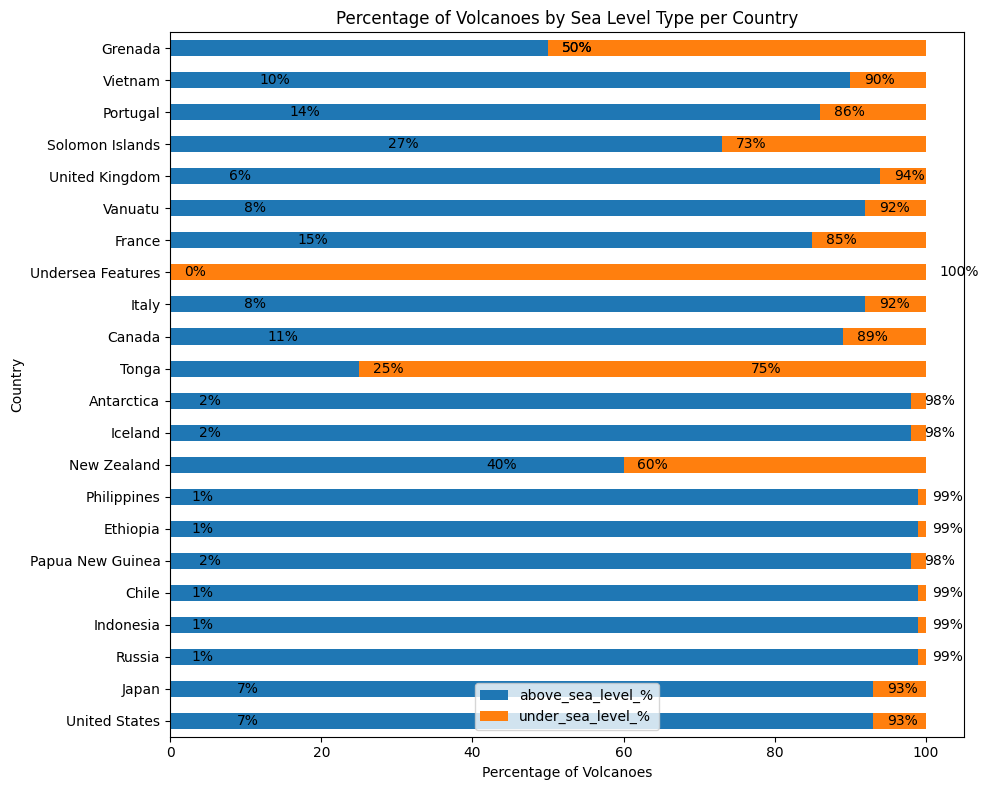

In [70]:
# Plot the horizontal stacked bar chart
ax = volcano_sea_level_by_country[['above_sea_level_%', 'under_sea_level_%']].plot(
    kind='barh', 
    stacked=True,
    figsize=(10, 8)
)

# Annotate the bars with rounded percentages
for p in ax.patches:
    ax.annotate(f"{p.get_width():.0f}%", (p.get_width(), p.get_y() + p.get_height() / 2.), va='center', xytext=(10, 0), textcoords='offset points')

plt.title('Percentage of Volcanoes by Sea Level Type per Country')
plt.xlabel('Percentage of Volcanoes')
plt.ylabel('Country')
plt.yticks(range(len(volcano_sea_level_by_country)), volcano_sea_level_by_country['country'])
plt.tight_layout()
plt.show()
